In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import matplotlib as mpl
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.314)
import scipy as sp
import multiprocessing as mp


import time
start_total = time.time()

In [2]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

In [3]:
zl = 0.2; zs = 1.2
Dl = cosmo.angular_diameter_distance(zl)   
Ds = cosmo.angular_diameter_distance(zs)    
Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
G = const.G
rho_crit = (cosmo.critical_density(zl)).to(u.kg/u.m**3)
c_light = (const.c).to(u.cm/u.second)

#r0 = 10*u.kpc
r0 = 10.0*u.kpc
#r0 = 0.1*u.kpc
pi = np.pi

def scale_radius(v,Dl,Ds,Dls):                               #this is e0 in eq 3.42 meneghetti, eq 1 barnacka 2014
    return (4.*pi*v**2/c_light**2*Dl*Dls/Ds).decompose()
def theta_E_SIS():
    'in arcsec'
    pre_theta_E = (scale_radius(v,Dl,Ds,Dls)/Dl).decompose()
    return pre_theta_E*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 

v = 180 *u.km/u.s
ss_r = scale_radius(v,Dl,Ds,Dls) 
print('scale radius (m): ',ss_r)
print('scale radius (kpc): ',ss_r.to(u.kpc))
print('theta_E: ',theta_E_SIS() ,'arcsec')
theta_E_num = theta_E_SIS()
elipt = 0.3
re = (const.e.esu**2/const.m_e/(c_light**2)).decompose()
print('Classic electron radius: ',re)

scale radius (m):  7.705329461274929e+19 m
scale radius (kpc):  2.49712721364453 kpc
theta_E:  0.7301786792241515 arcsec
Classic electron radius:  2.817940324670788e-15 m


In [4]:
# jet source

radius_3 = 0.5551103128497743

n = 200
t = np.linspace(0,1.3*radius_3*np.sqrt(2)/2,n)
t2 = np.linspace(0,1.3*1.11*radius_3*np.sqrt(2)/2,n)
a = 1.0
b = 0.9

x0 = -0.2*radius_3
y0 = -0.185*radius_3

x1 = 0.01*radius_3
y1 = 0.01*radius_3
x_source_1 = t + x0
y_source_1 = a*t + y0
x_source_2 = t2 + x0 + x1
y_source_2 = b*t2 + y0 - y1
        
mesh_x = []
mesh_y = []
n1 = 7  #n1 lower implies a higher number of points
for j in range(len(x_source_1)):
    for i in range(int(j/n1)):
        mesh_x.append(x_source_1[j]+j*0.02/n)
        z = np.linspace(y_source_2[j]-j*0.02/n, y_source_1[j]+j*0.02/n,int(j/n1))
        mesh_y.append(z[i])
        
mesh__x = []
mesh__y = []
limit = len(mesh_x) - int(n/n1)
for i in range(61):
    mesh_x[i] = 0.
    mesh_y[i] = 0.
for i in range(len(mesh_x)):
    if np.sqrt(mesh_x[i]**2+mesh_y[i]**2) < np.sqrt(mesh_x[limit]**2+mesh_y[limit]**2) and np.sqrt(mesh_x[i]**2+mesh_y[i]**2)>0.001:
        mesh__x.append(mesh_x[i])
        mesh__y.append(mesh_y[i])
        
mesh_x = mesh__x
mesh_y = mesh__y

k = np.array(mesh_y).argmin()
mesh_x[k] = 0
mesh_y[k] = 0

In [5]:
# count blobes from smaller to bigger
alpha = -(np.pi/4 + 1.5* np.pi/180)

rx_1 = 0.017/2
ry_1 = 5*rx_1
cx_1 = 0.12
cy_1 = 0.11+0.01*radius_3
rx_2 = 0.022/2
ry_2 = 5*rx_1
cx_2 = 0.18 
cy_2 = 0.167+0.01*radius_3
rx_3 = 0.027/2
ry_3 = 5*rx_3
cx_3 = 0.26
cy_3 = 0.245+0.01*radius_3 
rx_4 = 0.045/2
ry_4 = 4*rx_4
cx_4 = 0.37 
cy_4 = 0.35+0.01*radius_3   
mesh_light = []
for i in range(len(mesh_x)):
    if ( (mesh_x[i]-cx_1)*np.cos(alpha) + (mesh_y[i]-cy_1)*np.sin(alpha) )**2/rx_1**2 + \
( (mesh_x[i]-cx_1)*np.sin(alpha) - (mesh_y[i]-cy_1)*np.cos(alpha) )**2/ry_1**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_1)*np.cos(alpha) + (mesh_y[i]-cy_1)*np.sin(alpha) )**2/rx_1**2 + \
( (mesh_x[i]-cx_1)*np.sin(alpha) - (mesh_y[i]-cy_1)*np.cos(alpha) )**2/ry_1**2)
        light = np.exp(-r**2)
        mesh_light.append(light)
    elif ( (mesh_x[i]-cx_2)*np.cos(alpha) + (mesh_y[i]-cy_2)*np.sin(alpha) )**2/rx_2**2 + \
( (mesh_x[i]-cx_2)*np.sin(alpha) - (mesh_y[i]-cy_2)*np.cos(alpha) )**2/ry_2**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_2)*np.cos(alpha) + (mesh_y[i]-cy_2)*np.sin(alpha) )**2/rx_2**2 + \
( (mesh_x[i]-cx_2)*np.sin(alpha) - (mesh_y[i]-cy_2)*np.cos(alpha) )**2/ry_2**2)
        light = np.exp(-r**2)
        mesh_light.append(light)
    elif ( (mesh_x[i]-cx_3)*np.cos(alpha) + (mesh_y[i]-cy_3)*np.sin(alpha) )**2/rx_3**2 + \
( (mesh_x[i]-cx_3)*np.sin(alpha) - (mesh_y[i]-cy_3)*np.cos(alpha) )**2/ry_3**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_3)*np.cos(alpha) + (mesh_y[i]-cy_3)*np.sin(alpha) )**2/rx_3**2 + \
( (mesh_x[i]-cx_3)*np.sin(alpha) - (mesh_y[i]-cy_3)*np.cos(alpha) )**2/ry_3**2)
        light = np.exp(-r**2)
        mesh_light.append(light)
    elif ( (mesh_x[i]-cx_4)*np.cos(alpha) + (mesh_y[i]-cy_4)*np.sin(alpha) )**2/rx_4**2 + \
( (mesh_x[i]-cx_4)*np.sin(alpha) - (mesh_y[i]-cy_4)*np.cos(alpha) )**2/ry_4**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_4)*np.cos(alpha) + (mesh_y[i]-cy_4)*np.sin(alpha) )**2/rx_4**2 + \
( (mesh_x[i]-cx_4)*np.sin(alpha) - (mesh_y[i]-cy_4)*np.cos(alpha) )**2/ry_4**2)
        light = np.exp(-r**2)
        mesh_light.append(light)    
    else:
        light = 1/np.e
        mesh_light.append(light)

In [6]:
def image_position(source):
    x_s, y_s,light = source
    x_pre, y_pre = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_list, \
                    sourcePos_x=x_s, sourcePos_y=y_s, min_distance=0.05, search_window=5, \
                    precision_limit=10**(-8), num_iter_max=100,non_linear=True)
    light_pre = []
    for k in range(len(x_pre)):
        light_pre = np.append(light_pre,light)
    return x_pre, y_pre, light_pre

def main(x1,x2,x3):
    start_p = time.time()
    x = x1
    y = x2
    l = x3
    
    with mp.Pool(mp.cpu_count()-1) as pool:
        out = pool.map(image_position, zip(x,y,l))
        
        xx = []; yy = []; ll = []
        for i in range(len(out)):
            x = out[i][0]
            xx.append(x)
            y = out[i][1]
            yy.append(y)
            l = out[i][2]
            ll.append(l)
        xx = np.concatenate(xx, axis=0)
        yy = np.concatenate(yy, axis=0)
        ll = np.concatenate(ll, axis=0)
    end_p = time.time()
    pool.close()
    print('time: ',(end_p-start_p)/60.,' minutes')
        
    return xx, yy, ll

In [7]:
lens_model_list = ['SIEBH']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)

In [8]:
kwargs = {'theta_E':theta_E_num.value,'eta':0*elipt, 'theta_E_1':0, 'x1':0, 'y1':0}
kwargs_lens_list = [kwargs]

In [9]:
lensModelExtensions = LensModelExtensions(lensModel=lensModel)

SSSbh = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

In [10]:
mesh_x_1 = np.array(mesh_x) - 0.2
mesh_y_1 = np.array(mesh_y) + 0.3

In [11]:
x_image_1, y_image_1, light_1 = main(mesh_x_1,mesh_y_1,mesh_light)

time:  0.19203782081604004  minutes


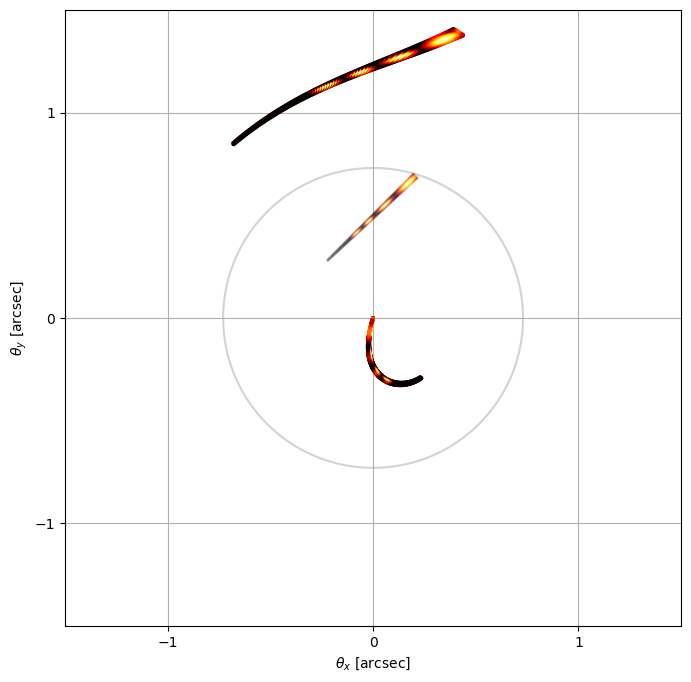

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_1,mesh_y_1, s =.002, c=mesh_light, cmap='hot',zorder = 2)
plt.plot(SSSbh[0][0],SSSbh[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSbh[2][0],SSSbh[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_1, y_image_1, c=light_1, cmap='hot', s = 3, zorder = 2)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.grid(zorder=1)
plt.show()

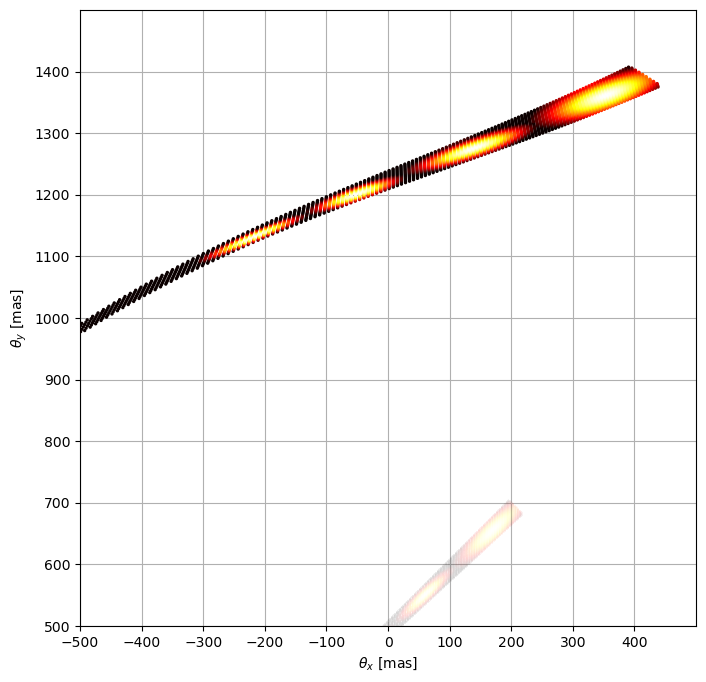

In [13]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-500, 500, 100))
ax.set_yticks(np.arange(500, 1500, 100))

plt.scatter(mesh_x_1*1e3,mesh_y_1*1e3, s =.002, c=mesh_light, cmap='hot',zorder = 2)
plt.plot(SSSbh[0][0],SSSbh[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSbh[2][0],SSSbh[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [mas]')
ax.set_ylabel(r'$\theta_{y}$ [mas]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_1*1e3, y_image_1*1e3, c=light_1, cmap='hot', s = 2, zorder = 3)
ax.set_xlim([-500, 500])
ax.set_ylim([500, 1500])
plt.grid(zorder = 1)
plt.show()

In [14]:
x1 = .14
y1 = 1.25

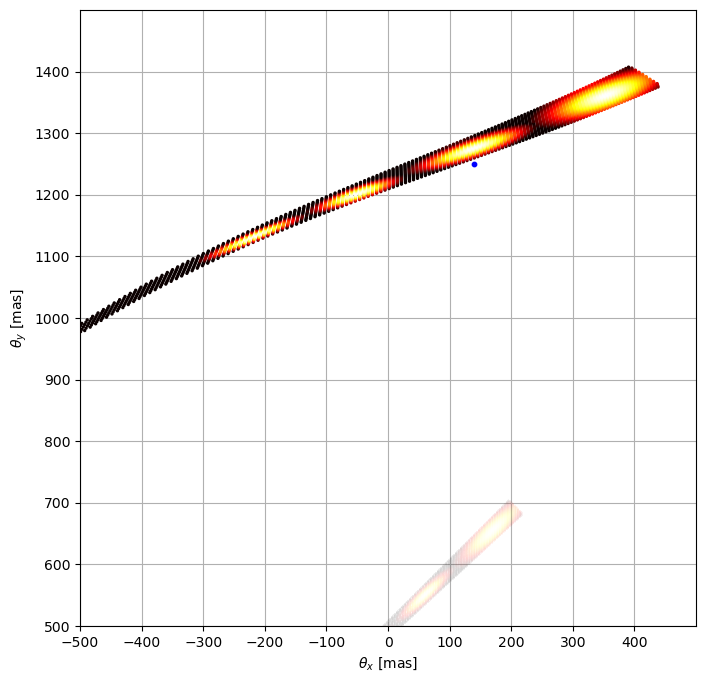

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-500, 500, 100))
ax.set_yticks(np.arange(500, 1500, 100))

plt.scatter(mesh_x_1*1e3,mesh_y_1*1e3, s =.002, c=mesh_light, cmap='hot',zorder = 2)
plt.plot(SSSbh[0][0],SSSbh[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSbh[2][0],SSSbh[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [mas]')
ax.set_ylabel(r'$\theta_{y}$ [mas]')

plt.scatter(x1*1e3, y1*1e3, s = 10 , color = 'blue', zorder = 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_1*1e3, y_image_1*1e3, c=light_1, cmap='hot', s = 2, zorder = 3)
ax.set_xlim([-500, 500])
ax.set_ylim([500, 1500])
plt.grid(zorder = 1)
plt.show()

The lensing potential by a point mass is given by 

$$
\psi = \frac{4GM}{c^2} \frac{D_{ls}}{D_l D_s} ln |\vec{\theta}|
$$

In terms of the Einstein radius

$$
\theta_{e_1} = \sqrt{\frac{4GM}{c^2} \frac{D_{ls}}{D_l D_s}} \\
\psi = \theta_{e_1}^2 ln |\vec{\theta}|
$$

Lets start with 

$$
M_1 = 10^3 M_\odot \\
M_2 = 10^4 M_\odot \\
M_3 = 10^5 M_\odot \\
M_4 = 10^6 M_\odot \\
M_5 = 10^8 M_\odot 
$$

In [16]:
ms = 1.98847e30*u.kg  #solar mass
m1 = ms*1e3
m2 = ms*1e4
m3 = ms*1e5
m4 = ms*1e6
m5 = ms*1e8

In [17]:
theta_E_1 = np.sqrt(4*G*m1/c_light**2*Dls/Dl/Ds)
theta_E_1 = theta_E_1.decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
theta_E_1.value

9.498356879908454e-05

In [18]:
theta_E_2 = np.sqrt(4*G*m2/c_light**2*Dls/Dl/Ds)
theta_E_2 = theta_E_2.decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
theta_E_2.value

0.0003003644176964114

In [19]:
theta_E_3 = np.sqrt(4*G*m3/c_light**2*Dls/Dl/Ds)
theta_E_3 = theta_E_3.decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
theta_E_3.value

0.0009498356879908454

In [20]:
theta_E_4 = np.sqrt(4*G*m4/c_light**2*Dls/Dl/Ds)
theta_E_4 = theta_E_4.decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
theta_E_4.value

0.0030036441769641137

In [21]:
theta_E_5 = np.sqrt(4*G*m5/c_light**2*Dls/Dl/Ds)
theta_E_5 = theta_E_5.decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
theta_E_5.value

0.030036441769641136

In [22]:
kwargs = {'theta_E':theta_E_num.value,'eta':0*elipt, 'theta_E_1':theta_E_1.value, 'x1':x1, 'y1':y1}
kwargs_lens_list = [kwargs]

In [23]:
x_image_bh_1, y_image_bh_1, light_bh_1 = main(mesh_x_1,mesh_y_1,mesh_light)

time:  0.1675709327061971  minutes


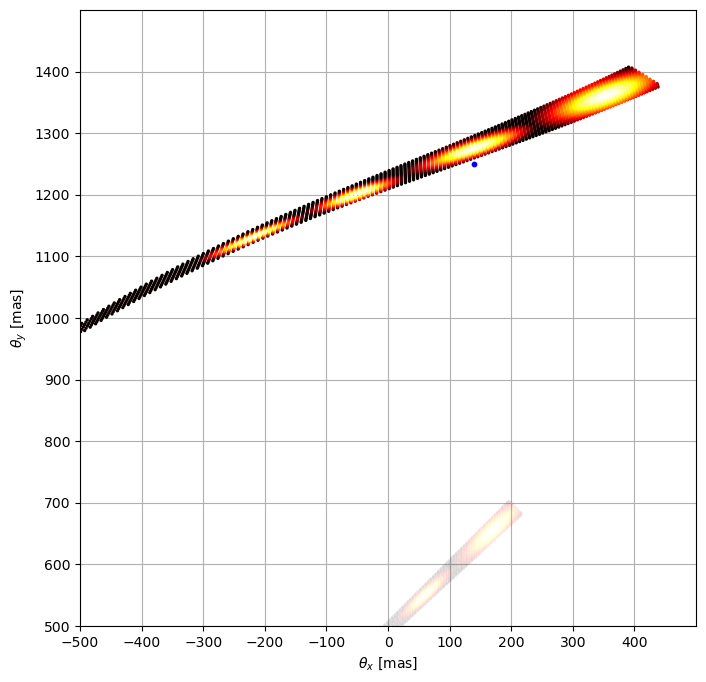

In [24]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-500, 500, 100))
ax.set_yticks(np.arange(500, 1500, 100))

plt.scatter(mesh_x_1*1e3,mesh_y_1*1e3, s =.002, c=mesh_light, cmap='hot',zorder = 2)
plt.plot(SSSbh[0][0],SSSbh[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSbh[2][0],SSSbh[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [mas]')
ax.set_ylabel(r'$\theta_{y}$ [mas]')

plt.scatter(x1*1e3, y1*1e3, s = 10 , color = 'blue', zorder = 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_bh_1*1e3, y_image_bh_1*1e3, c=light_bh_1, cmap='hot', s = 2, zorder = 3)
ax.set_xlim([-500, 500])
ax.set_ylim([500, 1500])
plt.grid(zorder = 1)
plt.show()

In [25]:
kwargs = {'theta_E':theta_E_num.value,'eta':0*elipt, 'theta_E_1':theta_E_4.value, 'x1':x1, 'y1':y1}
kwargs_lens_list = [kwargs]

In [26]:
x_image_bh_2, y_image_bh_2, light_bh_2 = main(mesh_x_1,mesh_y_1,mesh_light)

time:  0.1640423893928528  minutes


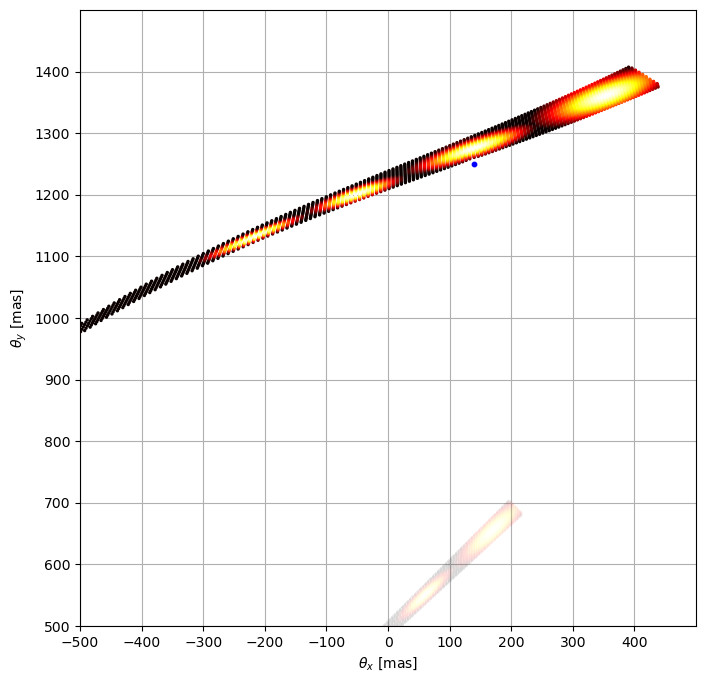

In [27]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-500, 500, 100))
ax.set_yticks(np.arange(500, 1500, 100))

plt.scatter(mesh_x_1*1e3,mesh_y_1*1e3, s =.002, c=mesh_light, cmap='hot',zorder = 2)
plt.plot(SSSbh[0][0],SSSbh[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSbh[2][0],SSSbh[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [mas]')
ax.set_ylabel(r'$\theta_{y}$ [mas]')

plt.scatter(x1*1e3, y1*1e3, s = 10 , color = 'blue', zorder = 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_bh_2*1e3, y_image_bh_2*1e3, c=light_bh_2, cmap='hot', s = 2, zorder = 3)
ax.set_xlim([-500, 500])
ax.set_ylim([500, 1500])
plt.grid(zorder = 1)
plt.show()

In [28]:
kwargs = {'theta_E':theta_E_num.value,'eta':0*elipt, 'theta_E_1':theta_E_5.value, 'x1':x1, 'y1':y1}
kwargs_lens_list = [kwargs]

In [29]:
x_image_bh_3, y_image_bh_3, light_bh_3 = main(mesh_x_1,mesh_y_1,mesh_light)

time:  0.16678863763809204  minutes


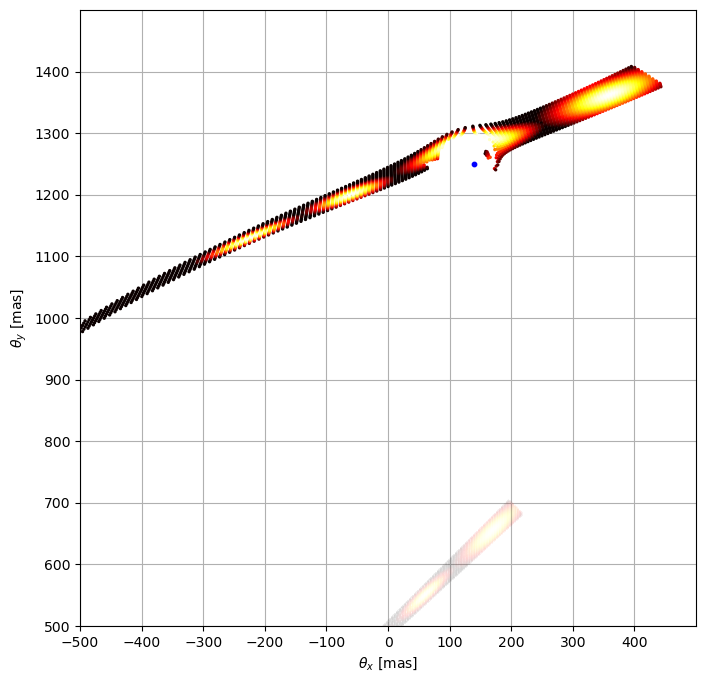

In [30]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-500, 500, 100))
ax.set_yticks(np.arange(500, 1500, 100))

plt.scatter(mesh_x_1*1e3,mesh_y_1*1e3, s =.002, c=mesh_light, cmap='hot',zorder = 2)
plt.plot(SSSbh[0][0],SSSbh[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSbh[2][0],SSSbh[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [mas]')
ax.set_ylabel(r'$\theta_{y}$ [mas]')

plt.scatter(x1*1e3, y1*1e3, s = 10 , color = 'blue', zorder = 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_bh_3*1e3, y_image_bh_3*1e3, c=light_bh_3, cmap='hot', s = 2, zorder = 3)
ax.set_xlim([-500, 500])
ax.set_ylim([500, 1500])
plt.grid(zorder = 1)
plt.show()

## Lets make a smaller jet

In [31]:
def image_position(source):
    x_s, y_s,light = source
    x_pre, y_pre = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_list, \
                    sourcePos_x=x_s, sourcePos_y=y_s, min_distance=.5e-3, search_window=.7, \
                    precision_limit=10**(-8), num_iter_max=100,non_linear=True)
    light_pre = []
    for k in range(len(x_pre)):
        light_pre = np.append(light_pre,light)
    return x_pre, y_pre, light_pre

In [32]:
rj = np.linspace(0,1e-3,70)

jet__x = []
jet__y = []
jet__light = []
for r in range(len(rj)):
    n = int(rj[r]/1e-3*100)
    #n = 350
    theta = np.linspace(0,2*np.pi,n)
    xarray = 6*rj[r]*np.cos(theta)
    yarray = 2*rj[r]*np.sin(theta)
    light = np.exp(-rj[r]**2)
    light_arr = np.full((n, ), light)
    
    for j in xarray:
        jet__x.append(j)
    for j in yarray:
        jet__y.append(j)
    for j in light_arr:
        jet__light.append(j)

jet__x = np.array(jet__x)
jet__y = np.array(jet__y)
jet__light = np.array(jet__light)

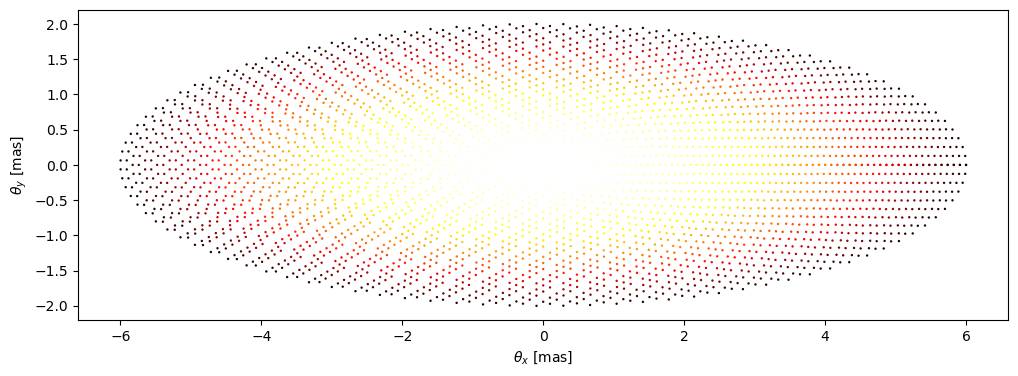

In [33]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()

plt.scatter(jet__x*1e3, jet__y*1e3, s = .5,  c =jet__light, cmap='hot')
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xlabel(r'$\theta_{x}$ [mas]')
ax.set_ylabel(r'$\theta_{y}$ [mas]')
plt.show()

In [34]:
jet_x = jet__x + .25
jet_y = jet__y + .25 
jet_light = jet__light

In [35]:
x1 = -0.26631755 + 2e-3
y1 = -0.26631755 

### $ M_3 = 10^5 M_\odot$

In [36]:
kwargs = {'theta_E':theta_E_num.value,'eta':0*elipt, 'theta_E_1':theta_E_3.value, 'x1':x1, 'y1':y1}
kwargs_lens_list = [kwargs]

In [37]:
x_image_jet_1, y_image_jet_1, light_jet_1 = main(jet_x,jet_y,jet_light)

time:  17.349308892091116  minutes


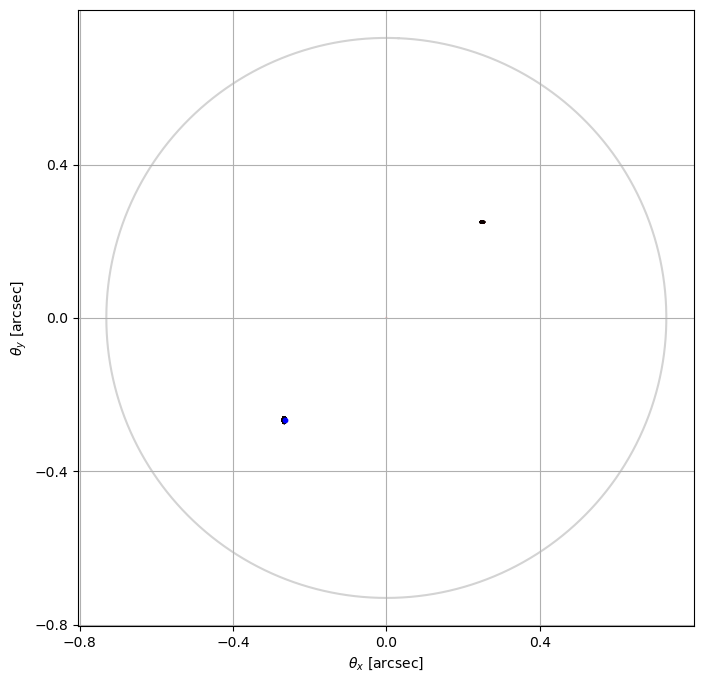

In [38]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.scatter(x_image_jet_1, y_image_jet_1, c=light_jet_1, cmap='hot', s = 2, zorder = 3)
plt.scatter(x1, y1, s = 10, color = 'blue', zorder = 4)

ax.set_xticks(np.arange(-.8, .8, .4))
ax.set_yticks(np.arange(-.8, .8, .4))
plt.scatter(jet_x,jet_y, s =.002, c=jet_light, cmap='hot',zorder = 2)
plt.plot(SSSbh[0][0],SSSbh[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSbh[2][0],SSSbh[3][0], color = '#ffd1d1',zorder=1)

plt.grid(zorder = 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [39]:
x0 = y0 = - 0.26631755

x_image_jet_1_ = x_image_jet_1 - x0
y_image_jet_1_ = y_image_jet_1 - y0
x1_ = x1 - x0
y1_ = y1 - y0

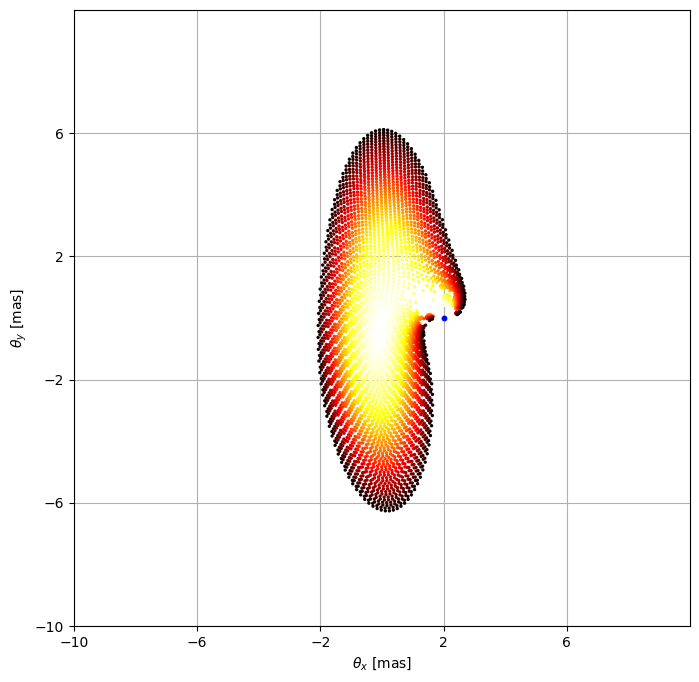

In [62]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax.set_xlabel(r'$\theta_{x}$ [mas]')
ax.set_ylabel(r'$\theta_{y}$ [mas]')
plt.scatter(x_image_jet_1_*1e3, y_image_jet_1_*1e3, c=light_jet_1, cmap='hot', s = 2, zorder = 3)
plt.scatter(x1_*1e3, y1_*1e3, s = 10, color = 'blue', zorder = 4)
ax.set_xticks(np.arange(-10, 10, 4))
ax.set_yticks(np.arange(-10, 10, 4))
plt.grid(zorder = 1)
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
plt.show()

### $ M_4 = 10^6 M_\odot$

In [41]:
kwargs = {'theta_E':theta_E_num.value,'eta':0*elipt, 'theta_E_1':theta_E_4.value, 'x1':x1, 'y1':y1}
kwargs_lens_list = [kwargs]

In [42]:
x_image_jet_2, y_image_jet_2, light_jet_2 = main(jet_x,jet_y,jet_light)

time:  17.375059076150258  minutes


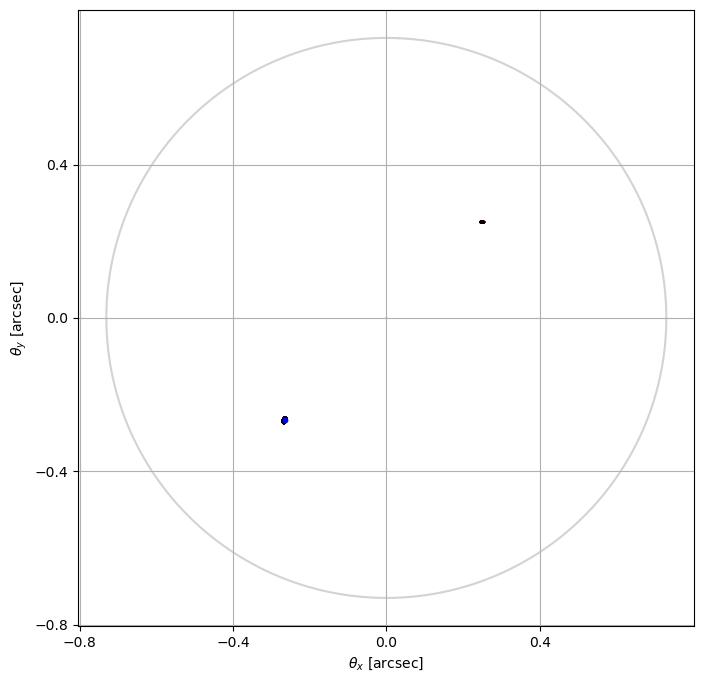

In [43]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.scatter(x_image_jet_2, y_image_jet_2, c=light_jet_2, cmap='hot', s = 2, zorder = 3)
plt.scatter(x1, y1, s = 10, color = 'blue', zorder = 4)

ax.set_xticks(np.arange(-.8, .8, .4))
ax.set_yticks(np.arange(-.8, .8, .4))
plt.scatter(jet_x,jet_y, s =.002, c=jet_light, cmap='hot',zorder = 2)
plt.plot(SSSbh[0][0],SSSbh[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSbh[2][0],SSSbh[3][0], color = '#ffd1d1',zorder=1)

plt.grid(zorder = 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [48]:
x0 = y0 = - 0.26631755

x_image_jet_2_ = x_image_jet_2 - x0
y_image_jet_2_ = y_image_jet_2 - y0
x1_ = x1 - x0
y1_ = y1 - y0

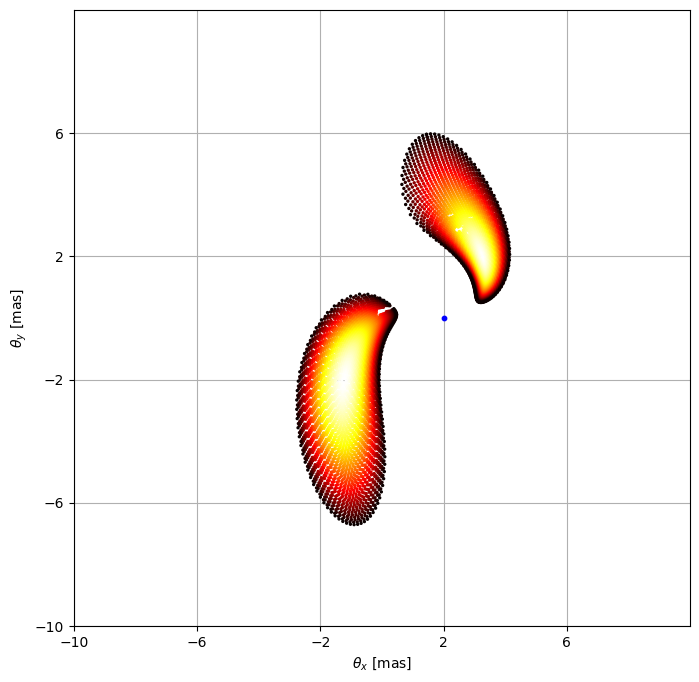

In [60]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax.set_xlabel(r'$\theta_{x}$ [mas]')
ax.set_ylabel(r'$\theta_{y}$ [mas]')
plt.scatter(x_image_jet_2_*1e3, y_image_jet_2_*1e3, c=light_jet_2, cmap='hot', s = 2, zorder = 3)
plt.scatter(x1_*1e3, y1_*1e3, s = 10, color = 'blue', zorder = 4)
plt.grid(zorder = 1)
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xticks(np.arange(-10, 10, 4))
ax.set_yticks(np.arange(-10, 10, 4))
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
plt.show()

In [47]:
end_total = time.time()
print('total time: ',(end_total-start_total)/60.,' minutes')

total time:  36.21441366275152  minutes
